# Simple Example

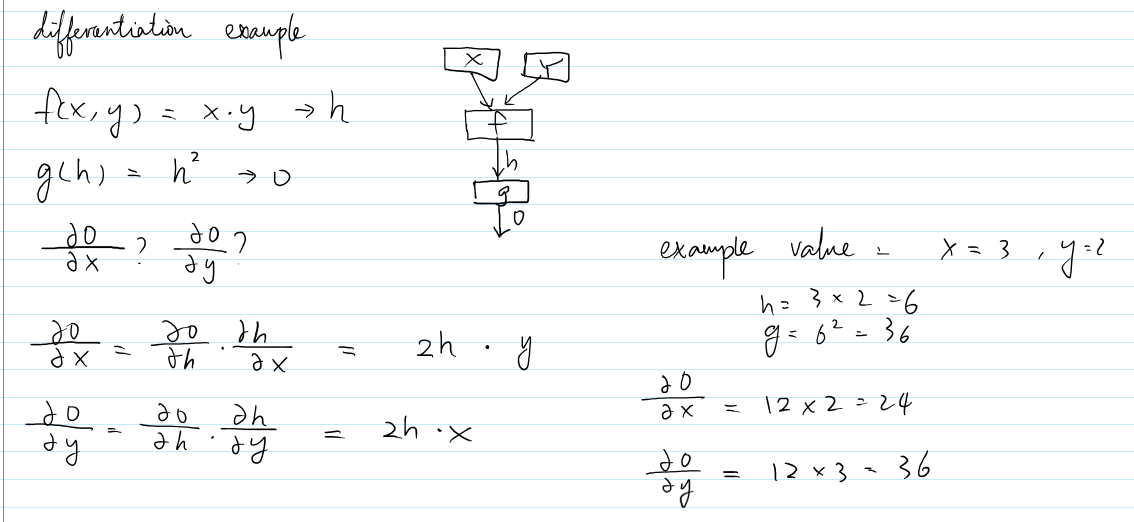

$$\nabla f = [y, x]^{\top}$$
$$\nabla g = [2h]^{\top}$$

In [1]:
import numpy as np

In [2]:
class ComputeNode(object):
    def __init__(self, tape):
        self.tape = tape
    
    def forward(self):
        raise NotImplementedError
    
    def backward(self):
        raise NotImplementedError

In [3]:
class F(ComputeNode):
    def forward(self, inputs):
        self.tape[self] = inputs
        out = inputs[0] * inputs[1]
        return np.atleast_1d(out)
    
    def backward(self, grad):
        inputs = self.tape[self]
        return np.array([inputs[1], inputs[0]]) * grad
        
class G(ComputeNode):
    def forward(self, inputs):
        self.tape[G] = inputs
        out = np.atleast_1d(inputs[0] ** 2)
        return out
    
    def backward(self, grad):
        return (self.tape[G] * 2) * grad

In [4]:
tape = {}
f = F(tape)
g = G(tape)

In [5]:
x = 3
y = 2

In [6]:
inputs = np.array([x, y])

In [7]:
outputs = f.forward(inputs)
print(outputs)
outputs = g.forward(outputs)
print(outputs)

[6]
[36]


In [8]:
grads = g.backward(np.array([1]))
print(grads)
grads = f.backward(grads)
print(grads)

[12]
[24 36]


# An intricate chain rule example

[link](https://cs231n.github.io/optimization-2/#backprop)

$$f(x, y)=\frac{x+\sigma(y)}{\sigma(x)+(x+y)^{2}}$$

In [9]:
import math

In [10]:
x = 3 # example values
y = -4

# forward pass
sigy = 1.0 / (1 + math.exp(-y)) # sigmoid in numerator   #(1)
num = x + sigy # numerator                               #(2)
sigx = 1.0 / (1 + math.exp(-x)) # sigmoid in denominator #(3)
xpy = x + y                                              #(4)
xpysqr = xpy**2                                          #(5)
den = sigx + xpysqr # denominator                        #(6)
invden = 1.0 / den                                       #(7)
f = num * invden # done!                                 #(8)

In [11]:
# backprop f = num * invden
dx = 0
dy = 0

dnum = invden
dx += 1 * dnum
dy += (1 - sigy) * sigy * dnum

dinvden = num
dden = - (1 / den) ** 2 * dinvden
dsigx = dden
dx += (1 - sigx) * sigx * dsigx
dxpysqr = dden
dx += (2 * x + 2 * y) * dxpysqr
dy += (2 * y + 2 * x) * dxpysqr

print(dx, dy)

2.0595697955721652 1.5922327514838093


# Fully Connected for Prediction

In [4]:
import torch
import torchvision

In [5]:
batch_size = 32

In [6]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/tmp/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size, shuffle=True, 
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/tmp/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size, shuffle=True
)

In [7]:
class Layer(object):
    def forward(self):
        raise NotImplementedError
    
    def backward(self):
        raise NotImplementedError

In [8]:
A = np.random.randn(3, 2).round(1)
B = np.random.randn(2, 1).round(1)
print(A)
print(B)
print(A * B.squeeze())

[[ 0.8 -0.5]
 [-0.1  1.6]
 [-0.1  0.4]]
[[0.1]
 [0.1]]
[[ 0.08 -0.05]
 [-0.01  0.16]
 [-0.01  0.04]]


In [9]:
x = torch.randn((6, 3))
A1 = torch.randn((2, 3), requires_grad=True)
b1 = torch.randn((2,), requires_grad=True)
A2 = torch.randn((1, 2), requires_grad=True)
b2 = torch.randn((1,), requires_grad=True)
y = (((x @ A1.T) + b1) @ A2.T + b2)
y.retain_grad()
loss = y.sum()
loss.retain_grad()
loss.backward()
loss.grad_fn

In [10]:
# dA: [n d_out d_out d_in]
# dA (short): [n d_in]
# grads: [n d_out]
# grads @ dA: [d_out d_in]
# chain_dA: [d_out d_in]

In [60]:
x = np.random.randn(4, 3, 2).round(1)
y = np.random.randn(2).round(1)
z = x * y
print(x.shape, y.shape, z.shape)
print()
print(x)
print(y)
print(z)

(4, 3, 2) (2,) (4, 3, 2)

[[[-0.4  0.2]
  [ 0.4 -0.6]
  [ 1.5  1.6]]

 [[ 0.1  0.5]
  [ 0.5 -0.9]
  [-0.   0.3]]

 [[-0.7  0.1]
  [ 0.7 -1.4]
  [-1.3 -0.1]]

 [[ 1.3 -1.2]
  [ 0.   0.3]
  [ 0.1  0.4]]]
[ 0.4 -0.1]
[[[-0.16 -0.02]
  [ 0.16  0.06]
  [ 0.6  -0.16]]

 [[ 0.04 -0.05]
  [ 0.2   0.09]
  [-0.   -0.03]]

 [[-0.28 -0.01]
  [ 0.28  0.14]
  [-0.52  0.01]]

 [[ 0.52  0.12]
  [ 0.   -0.03]
  [ 0.04 -0.04]]]


In [90]:
class MLP(Layer):
    def __init__(self, d_in, d_out):
        self.d_in = d_in
        self.d_out = d_out
        self.A = np.random.randn(d_out, d_in) * np.sqrt(2 / d_in)
        self.b = np.zeros(d_out)
        
        self.dx = np.zeros((d_out, d_in))
        self.db = np.zeros(d_out)
        self.dA = None  # based on batch_size, [d_out, n]
        
        self.chain_dx = None
        self.chain_db = None
        self.chain_dA = None
        
        self.inputs = None
        
    def forward(self, x):
        self.inputs = x
        
        self.dx += self.A  # [d_out d_in]
        self.db += np.ones_like(self.b)  # [d_out]
        if self.dA is None:
            self.dA = np.zeros_like(x)
        self.dA += x  # [n d_in]
            
        return x @ self.A.T + self.b
    
    def backward(self, grads, alpha=0.01):
        # A: [d_out d_in]
        # x: [n d_in]
        # b: [d_out]
        # grads: [n d_out]
        n = grads.shape[0]
        
        chain_dA = np.zeros_like(self.A)
        for idx in range(n):
            chain_dA += np.outer(grads[idx], self.dA[idx])
        self.chain_dA = chain_dA
        
        chain_db = grads.sum(axis=0) * self.db
        self.chain_db = chain_db
        
        chain_dx = np.zeros_like(x)  # [n d_in]
        chain_dx = grads @ self.dx
            
        return chain_dx
    
class ReLu(Layer):
    def forward(self, x):
        return x * (x > 0)
    
    def backward(self, grads):
        pass

class Softmax(Layer):
    def forward(self, x):
        exp = np.exp(x)
        return exp / np.sum(exp, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_target):
    v = np.zeros_like(y_pred)
    v[np.arange(y_target.size), y_target] = 1
    return -np.sum(v * np.log(y_pred), axis=1)

class CrossEntropyLoss(Layer):
    def forward(self, y_pred, y_target):
        exp = np.exp(x)
        return exp / np.sum(exp, axis=1, keepdims=True)

## Gradient Check

In [91]:
def comp_gradients(a, b):
    print('diff: ', (a - b).sum())
    relative_error_max = np.max(np.abs(np.append(a, b)))
    return np.mean(np.abs(a - expected_grad) / relative_error_max)

In [92]:
def forward(layers, x):
    for layer in layers:
        x = layer.forward(x)
    return x

def backward(layers, grads):
    for layer in reversed(layers):
#         print('grads.shape', grads.shape)
        grads = layer.backward(grads)
    return grads

In [93]:
n = 4
d_1 = 3
d_2 = 2
d_3 = 1

In [94]:
x = np.random.randn(n, d_1).round(1)

mlp = MLP(d_1, d_2)
mlp.A = mlp.A.round(1)
mlp2 = MLP(d_2, d_3)
mlp2.A = mlp2.A.round(1)
layers = [mlp, mlp2]

y = forward(layers, x)
grads = backward(layers, np.ones((n, d_3)))

print('x', x)
print()
print('mlp.A', mlp.A)
print()
print('mlp2.A', mlp2.A)
print()
print('y', y)
print()
print('grads', grads)
print()
print('chain_dA', mlp.chain_dA)
print('chain_db', mlp.chain_db)

x [[ 0.6 -0.7  0.4]
 [-2.9  0.   2.2]
 [-0.4  0.1 -0.2]
 [-1.9  0.9  0.3]]

mlp.A [[0.2 0.2 0.7]
 [0.1 0.2 1.4]]

mlp2.A [[-1.3  1.6]]

y [[ 0.43 ]
 [ 3.216]
 [-0.22 ]
 [ 0.643]]

grads [[-0.1   0.06  1.33]
 [-0.1   0.06  1.33]
 [-0.1   0.06  1.33]
 [-0.1   0.06  1.33]]

chain_dA [[ 5.98 -0.39 -3.51]
 [-7.36  0.48  4.32]]
chain_db [-5.2  6.4]


In [95]:
x = torch.from_numpy(x)
A1 = torch.from_numpy(mlp.A)
A1.requires_grad = True
b1 = torch.from_numpy(mlp.b)
b1.requires_grad = True
A2 = torch.from_numpy(mlp2.A)
A2.requires_grad = True
b2 = torch.from_numpy(mlp2.b)
b2.requires_grad = True
y = ((x @ A1.T + b1) @ A2.T + b2)
loss = y.sum()
loss.retain_grad()
loss.backward()
b1.grad

tensor([-5.2000,  6.4000], dtype=torch.float64)

In [76]:
# delta = np.random.randn(*x.shape) * 0.01
delta = np.ones_like(x)

y_plus_delta = forward(layers, x + delta)
y_minus_delta = forward(layers, x - delta)

print(delta)
print()
print(y_plus_delta)
print()
print(y_minus_delta)
print()
print((y_plus_delta - y_minus_delta) / (2 * delta))

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]

[[-0.745]
 [-0.625]
 [ 0.255]
 [-1.888]]

[[ 0.315]
 [ 0.435]
 [ 1.315]
 [-0.828]]

[[-0.53 -0.53 -0.53]
 [-0.53 -0.53 -0.53]
 [-0.53 -0.53 -0.53]
 [-0.53 -0.53 -0.53]]


In [196]:
grads = np.ones((n, d_3, 1))
computed_grads = backward(layers, grads)
print(computed_grads.squeeze())

delta = np.random.randn(*x.shape) * 0.01
# print(delta)

y_plus_delta = forward(layers, x + delta)
y_minus_delta = forward(layers, x - delta)
expected_grad = (y_plus_delta - y_minus_delta) / (2 * delta)

print(expected_grad)

comp_gradients(computed_grads.sum(axis=1), expected_grad)

[[-0.00606117 -0.00531535  0.00386817]
 [-0.00606117 -0.00531535  0.00386817]
 [-0.00606117 -0.00531535  0.00386817]
 [-0.00606117 -0.00531535  0.00386817]]
[[ 0.00922265 -0.00670196  0.00447652]
 [-0.00492004 -0.05007442 -0.01144147]
 [-0.91965244  0.00449755  0.00177827]
 [ 0.04859474 -0.01594757  0.00488759]]
-0.030033387614267392 -0.935280585015095
diff:  0.8451804221722929


0.09867718857347035

In [302]:
x = np.random.randn(n, d_in)
mlp = MLP(d_in, d_out)
y = mlp.forward(x)

print(f"x: {x}\n")
print(f"A: {mlp.A}\n")
print(f"y: {y}\n")

x: [[-0.25725262  1.00638811 -0.01299258]
 [-0.25434853 -0.12489272 -1.11936699]]

A: [[ 0.41748111  0.35518526 -0.6587868 ]
 [ 0.91023125  0.2100981  -0.31606834]
 [ 1.11907798  0.23350302 -0.24875965]
 [ 0.23843081  0.43565496 -1.12978868]]

y: [[ 0.25861545 -0.0186126  -0.04965905  0.3917799 ]
 [ 0.58687843  0.09604076 -0.03534534  1.14959349]]



(2, 3, 3)

In [16]:
in_features = 784

In [17]:
# sanity check
data, target = next(iter(train_loader))
data = data.reshape(batch_size, -1)
data = data.numpy()
target = target.numpy()

print(data.shape)
print(target.shape)

(32, 784)
(32,)


In [286]:
layers = [
    MLP(in_features, 32),
    ReLu(),
    MLP(32, 10),
    ReLu(),
    Softmax()
]

x = data
for layer in layers:
    x = layer.forward(x)
loss = cross_entropy_loss(x, target)

In [287]:
grads = 1
for layer in layers:
    grads = layer.backward(grads)
print(grads)

TypeError: backward() takes 1 positional argument but 2 were given